In [1]:
# Standard library imports
import datetime as dt
import json
import os
import sys
import time
import traceback
import argparse

# Third-party imports
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import interpolate
from filelock import FileLock
from itertools import chain
from torch.profiler import profile, record_function, ProfilerActivity
from torchdiffeq import odeint
from torch.distributions import Categorical, Normal, kl_divergence
import matplotlib.pyplot as plt
import tqdm
import random
import ast

# PyTorch related imports
import torch
import torch.nn as nn

# Utilities and custom modules
import lib.utils as utils
import lib.models as models
import lib.train_functions as train_functions
import lib.encoders as encoders
from lib.HHS_data import *

# Setting the number of threads for PyTorch and specifying the device
torch.set_num_threads(1)

In [2]:
num = 0
df = pd.read_csv('validation_scores.csv', index_col=0)
df = df.sort_values('score')

idx = df.iloc[num].name
params = df.iloc[num]

year = 2016


In [3]:
    def convert_data(inputs, outputs, year=2015, batch_size=32):
        train_dates = {
            2015: {'start': dt.date(2004, 3, 24), 'end': dt.date(2015, 8, 12)},
            2016: {'start': dt.date(2004, 3, 24), 'end': dt.date(2016, 8, 11)},
            2017: {'start': dt.date(2004, 3, 24), 'end': dt.date(2017, 8, 10)},
            2018: {'start': dt.date(2004, 3, 24), 'end': dt.date(2018, 8, 9)}
        }

        test_dates = {
            2015: {'start': dt.date(2015, 10, 19), 'end': dt.date(2016, 5, 14)},
            2016: {'start': dt.date(2016, 10, 17), 'end': dt.date(2017, 5, 13)},
            2017: {'start': dt.date(2017, 10, 16), 'end': dt.date(2018, 5, 12)},
            2018: {'start': dt.date(2018, 10, 15), 'end': dt.date(2019, 5, 11)}
        }

        tr_start_idx = np.where([train_dates[year]['start'] == d for d in dates])[0][0]
        tr_end_idx = np.where([train_dates[year]['end'] == d for d in dates])[0][0]
        te_start_idx = np.where([test_dates[year]['start'] == d for d in dates])[0][0]
        te_end_idx = np.where([test_dates[year]['end'] == d for d in dates])[0][0]

        x_tr, y_tr = inputs[tr_start_idx:tr_end_idx], outputs[tr_start_idx:tr_end_idx]
        x_test, y_test = inputs[te_start_idx:te_end_idx], outputs[te_start_idx:te_end_idx]

        x_train = [x_tr[b * batch_size:(b + 1) * batch_size] for b in range(int(np.ceil(x_tr.shape[0] / batch_size)))]
        y_train = [y_tr[b * batch_size:(b + 1) * batch_size] for b in range(int(np.ceil(y_tr.shape[0] / batch_size)))]

        return x_train, y_train, x_test, y_test

    window = 35
    lag = 14
    n_regions = 10
    lr = 1e-3
    n_samples = 128
    device = 'cpu'
    torch.set_num_threads(1)
    dtype=torch.float32

    n_qs = int(params['n_qs'])
    latent_dim = int(params['latent_dim'])
    means = ast.literal_eval(params['means'])
    stds = ast.literal_eval(params['stds'])
    q_sizes = ast.literal_eval(params['q_sizes'])
    ff_sizes = ast.literal_eval(params['ff_sizes'])
    ili_sizes = ast.literal_eval(params['ili_sizes'])
    SIR_scaler = ast.literal_eval(params['SIR_scaler'])
    anneal = int(params['anneal'])
    epochs = int(params['epochs'])
    enc_name = params['enc_name']

    if enc_name == 'Encoder_BiDirectionalGRU':
        encoder_model = encoders.Encoder_BiDirectionalGRU
        run_backward = False
    if enc_name == 'Encoder_MISO_GRU':
        encoder_model = encoders.Encoder_MISO_GRU
        run_backward = False
    if enc_name == 'Encoder_Back_GRU':
        encoder_model = encoders.Encoder_Back_GRU
        run_backward = True

    if encoder_model == encoders.Encoder_Back_GRU:   
        gamma = 28
    else:
        gamma = 63

    ili = load_ili('hhs')
    ili = intepolate_ili(ili)

    hhs_dict = {}
    qs_dict = {}

    ignore = ['VI', 'PR']
    for i in range(1,1+n_regions):
        hhs_dict[i] = get_hhs_query_data(i, ignore=ignore, smooth_after = True)
        qs_dict[i] = choose_qs(hhs_dict, ili, i, year, n_qs)

        hhs_dict[i] = hhs_dict[i].loc[:, list(qs_dict[i])]
        hhs_dict[i] = hhs_dict[i].div(hhs_dict[i].max())
        
    ili = ili.loc[hhs_dict[i].index[0] : hhs_dict[i].index[-1]]
    ili = ili.div(ili.max())

    inputs = []
    outputs = []
    dates = []
    for batch in range(ili.shape[0] - (window+gamma)):
        batch_inputs = []
        for i in range(1,11):
            batch_inputs.append(hhs_dict[i].iloc[batch:batch+window+1])
        
        t_ili = ili.iloc[batch:batch+window+1].copy()
        t_ili.iloc[-lag:, :] = -1
        dates.append(pd.to_datetime(t_ili.index[-15]).date())
        batch_inputs.append(t_ili)
        batch_inputs = np.concatenate(batch_inputs, -1)

        if run_backward:
            gamma = 28
            batch_outputs = ili.iloc[batch:batch+window-lag+gamma+1].values
            t = torch.linspace(0, batch_outputs.shape[0]-1, batch_outputs.shape[0])/7
        else:
            gamma = 56
            batch_outputs = ili.iloc[batch+window-lag:batch+window-lag+gamma+1].values
            t = torch.linspace(0, batch_outputs.shape[0]-1, batch_outputs.shape[0])/7
            
        inputs.append(batch_inputs)
        outputs.append(batch_outputs)
    inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32)
    outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32)


    batch_size = 32
    new_inputs = torch.tensor(np.asarray(inputs), dtype=torch.float32).to(device)
    new_outputs = torch.tensor(np.asarray(outputs), dtype=torch.float32).to(device)


    x_train, y_train, x_test, y_test = convert_data(new_inputs, new_outputs, year = year, batch_size = 32)

In [4]:
class FaFp(nn.Module):
    def __init__(self, n_region=1, latent_dim=8, nhidden=32, nhidden_fa=32):
        super(FaFp, self).__init__()

        def make_mat(size):
            size = 10
            cols = np.sum([s for s in range(size)])
            mat = np.zeros((size, cols))

            r_u = 0
            r_l = 1
            c = 0

            for c in range(cols):
                mat[r_u, c] = 1
                mat[r_l, c] = -1

                r_l += 1
                if r_l == size:
                    r_u += 1
                    r_l = r_u + 1
            return mat


        self.n_region = n_region
        self.latent_dim = latent_dim

        

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_region*latent_dim, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, 2*n_region),
        )
        
        self.params = []

        size = np.sum([s for s in range(n_region)])
        self.augnet = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_region*latent_dim, nhidden_fa),
            nn.ELU(inplace=True),
            nn.Linear(nhidden_fa, nhidden_fa),
            nn.ELU(inplace=True),
            nn.Linear(nhidden_fa, size),
            nn.Linear(size, n_region),
        )

        with torch.no_grad():
            weight_mat = torch.from_numpy(make_mat(n_region)).float()
            self.augnet[-1].weight.copy_(weight_mat)
        
        self.params = []

    def forward(self, t, x):
        out_of_range_mask = (x > 2) | (x < -1)
        out = torch.abs(self.net(x)).reshape(-1, self.n_region, 2)
        aug = self.augnet(x)
        
        self.params.append(out)

        plusI = out[..., 0] * x[..., 0] * x[..., 1]
        minusI = out[..., 1] * x[..., 1]

        Fp = torch.stack([-plusI, aug+plusI - minusI, minusI], dim=-1)
        
        res = torch.cat([Fp, torch.zeros_like(x[..., 3:])], -1)
        res[out_of_range_mask] = 0.0
        return res
    
    def clear_tracking(self):
        """Resets the trackers."""
        self.params = []
    
    def posterior(self):
        params = torch.stack(self.params).reshape(-1, 2)
        
        self.params = []
        return Normal(params.mean(0), params.std(0))

In [5]:
enc = encoder_model(n_regions, 
                n_qs=n_qs,
                latent_dim = latent_dim-1,    
                q_sizes=q_sizes, 
                ili_sizes=ili_sizes, 
                ff_sizes = ff_sizes, 
                SIR_scaler = SIR_scaler, 
                device=device, 
                dtype=torch.float32)

ode = FaFp(n_regions, latent_dim, nhidden=64)
dec = models.Decoder(n_regions, 3, 1, device=device)

enc.to(device)
ode.to(device)
dec.to(device)

# torch.save(enc.state_dict(), enc_file)
# torch.save(dec.state_dict(), dec_file)
# torch.save(ode.state_dict(), ode_file)

suppress_outputs = False
if not suppress_outputs:
    num = np.sum([np.prod(_.shape) for _ in list(enc.parameters())])
    print('encoder parameters:', num)
    
    num = np.sum([np.prod(_.shape) for _ in list(ode.parameters())])
    print('ode parameters:', num)
    
    num = np.sum([np.prod(_.shape) for _ in list(dec.parameters())])
    print('decoder parameters:', num)

encoder parameters: 125292
ode parameters: 16237
decoder parameters: 310


In [ ]:
# pre train
print('pre training')
optimizer = torch.optim.Adam(enc.parameters(), lr=lr)
for epoch in range(3):
    kls = 0
    pbar = tqdm.tqdm(x_train, disable=suppress_outputs)
    num = 0
    for x_tr in pbar:
        optimizer.zero_grad()
        
        mean, std = enc(x_tr)
        prior = encoders.make_prior(mean, latent_dim=latent_dim, device=device)
        kl = kl_divergence(Normal(mean, std), prior).mean(0).sum()
        if torch.isnan(kl):
            break
        kl.backward()
        optimizer.step()
        kls += kl.cpu().detach().numpy()
        num += 1
        pbar.set_postfix({'Epoch':epoch, 'KL_z':kls/num})
        
optimizer = torch.optim.Adam(chain(enc.parameters(), ode.parameters(), dec.parameters()), lr=lr)
_history = train_functions.history()
kl_w = 1
step = 0

track_norms = []
print('training')
eval_pts = np.arange(0,t.shape[-1], 7)
for epoch in range(epochs):
    batch_grad_norms = []
    pbar = tqdm.tqdm(zip(x_train, y_train), disable=suppress_outputs)
    for x_tr, y_tr in pbar:
        batch_size = x_tr.shape[0]
        if anneal:
            step += 1 
            kl_w = train_functions.KL_annealing(step, reset_pos=10000, split=0.5, lower = 0.0, upper = 1.0, type = 'cosine')
        eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
        ode.clear_tracking()
        optimizer.zero_grad()

        mean, std = enc(x_tr)
        z = encoders.reparam(eps, std, mean, n_samples, batch_size)
        latent = odeint(ode, z, t[eval_pts], method='rk4', options=dict(step_size = 1.0))
        y_pred = dec(latent[..., :3]).reshape((-1, n_samples, batch_size, n_regions)).permute(2,1,0,3)

        nll = train_functions.nll_loss(y_pred, y_tr[:, eval_pts, :])
        kl_p = train_functions.get_kl_params(1, ode.posterior(), means=means, stds = stds,limit = 1e6, device=device)
        kl_z = kl_w*kl_divergence(encoders.make_prior(mean, latent_dim=latent_dim, device=device), Normal(mean, std)).sum(-1).mean() / len(x_train)
        reg_loss = 0*train_functions.latent_init_loss(latent[..., :3])

        loss = nll+kl_p+kl_z+reg_loss
        loss.backward()


        # Check gradient magnitudes
        grad_norm = torch.norm(torch.cat([p.grad.data.view(-1) for p in chain(enc.parameters(), ode.parameters(), dec.parameters())]), 2).item()
        batch_grad_norms.append(grad_norm)

        gradient_threshold = 300
        if grad_norm < gradient_threshold or epoch <= 3:
            optimizer.step()

        # _history.batch([loss.cpu(), nll.cpu(), kl_z.cpu(),kl_p.cpu(),reg_loss.cpu(), optimizer.param_groups[-1]['lr'], kl_w], ['loss', 'nll', 'kl_latent', 'kl_params', 'reg_loss', 'lr', 'kl_w'])
        _history.batch([round(loss.cpu().item(), 3), 
                        round(nll.cpu().item(), 3), 
                        round(kl_z.cpu().item(), 3), 
                        round(kl_p.cpu().item(), 3), 
                        round(reg_loss.cpu().item(), 3), 
                        round(optimizer.param_groups[-1]['lr'], 3), 
                        round(kl_w, 3), ], 
                        ['loss', 'nll', 'kl_latent', 'kl_params', 'reg_loss', 'lr', 'kl_w'])

        pbar.set_postfix(_history.epoch())
    _history.reset()

    if not suppress_outputs:
        with open('grad_norms.txt', 'a') as file:
            file.write(','.join(map(str, batch_grad_norms)) + '\n')

    rounded_epoch_history = {key: round(value, 3) for key, value in _history.epoch_history[-1].items()}
    rounded_epoch_history['grad_norm'] = max(batch_grad_norms)
    if suppress_outputs:
        print(epoch + 1, dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), rounded_epoch_history)
    utils.update_learning_rate(optimizer, 0.999, lr/10)

torch.save(enc.state_dict(), enc_file)
torch.save(dec.state_dict(), dec_file)
torch.save(ode.state_dict(), ode_file)

n_samples = 512
batch_size = x_test.shape[0]
eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
ode.clear_tracking()
mean, std = enc(x_test)
z = encoders.reparam(eps, std, mean, n_samples, batch_size)
latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
y_pred = dec(latent[..., :3]).reshape((t.shape[0], n_samples, batch_size, n_regions)).permute(2,1,0,3)
pred_mean = y_pred.mean(1)
pred_std = y_pred.std(1)
nll = train_functions.nll_loss(y_pred, y_test).detach().cpu().numpy()

results = {'ground_truth':y_test.numpy().tolist(),
        'mean':pred_mean.detach().numpy().tolist(),
        'std': pred_std.detach().numpy().tolist(),
        'nll':nll.item()}


# with open(save_file, 'w') as json_file:
#     json.dump(results, json_file)


pre training


100%|██████████| 142/142 [00:04<00:00, 33.76it/s, Epoch=2, KL_z=0.000373]


training


142it [03:59,  1.69s/it, loss=581, nll=-.408, kl_latent=581, kl_params=0.0348, reg_loss=0, lr=0.001, kl_w=0.000634]      
142it [03:58,  1.68s/it, loss=-.445, nll=-.453, kl_latent=0.000218, kl_params=0.00749, reg_loss=0, lr=0.001, kl_w=0.00465]
142it [03:56,  1.67s/it, loss=-.551, nll=-.556, kl_latent=0.000817, kl_params=0.00423, reg_loss=0, lr=0.001, kl_w=0.0126]
142it [03:58,  1.68s/it, loss=-.588, nll=-.592, kl_latent=0.000965, kl_params=0.00344, reg_loss=0, lr=0.001, kl_w=0.0244]
142it [03:58,  1.68s/it, loss=-.598, nll=-.602, kl_latent=0.00139, kl_params=0.00259, reg_loss=0, lr=0.001, kl_w=0.04]  
142it [03:57,  1.68s/it, loss=-.593, nll=-.6, kl_latent=0.00201, kl_params=0.00459, reg_loss=0, lr=0.001, kl_w=0.0592]  
142it [03:59,  1.69s/it, loss=-.608, nll=-.612, kl_latent=0.00232, kl_params=0.0022, reg_loss=0, lr=0.001, kl_w=0.082]  
142it [05:15,  2.22s/it, loss=-.605, nll=-.613, kl_latent=0.00264, kl_params=0.00473, reg_loss=0, lr=0.001, kl_w=0.108]
142it [05:33,  2.35s/it, los

In [15]:
n_samples = 512
batch_size = x_test.shape[0]
eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
ode.clear_tracking()
mean, std = enc(x_test)
z = encoders.reparam(eps, std, mean, n_samples, batch_size)
latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
y_pred = dec(latent[..., :3]).reshape((t.shape[0], n_samples, batch_size, n_regions)).permute(2,1,0,3)
pred_mean = y_pred.mean(1)
pred_std = y_pred.std(1)
nll = train_functions.nll_loss(y_pred, y_test).detach().cpu().numpy()

results = {'ground_truth':y_test.numpy().tolist(),
        'mean':pred_mean.detach().numpy().tolist(),
        'std': pred_std.detach().numpy().tolist(),
        'nll':nll.item()}


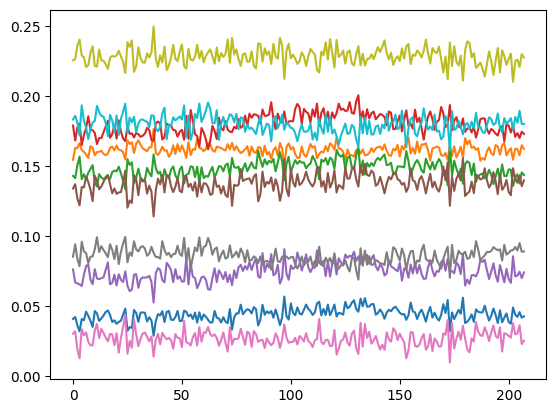

In [17]:
plt.plot(pred_mean.detach().numpy()[:, -28, :])

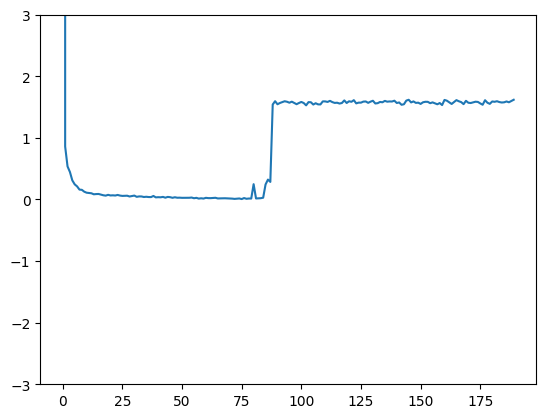

In [21]:
# plt.plot([h['loss'] for h in _history.epoch_history])
plt.plot([h['reg_loss'] for h in _history.epoch_history])
plt.ylim([-3,3])
plt.show()

In [20]:
_history.epoch_history[-1]

{'loss': 1.274049295774648,
 'nll': -0.6792394366197183,
 'kl_latent': 0.19195774647887323,
 'kl_params': 0.1425985915492958,
 'reg_loss': 1.6186830985915495,
 'lr': 0.001,
 'kl_w': 1.0}

In [ ]:
if __name__ == '__main__':
    import os
    import time
    import pandas as pd
    import numpy as np
    from filelock import FileLock

    num = 0
    suppress_outputs = True

    # Use FileLock for reading and modifying the DataFrame
    with FileLock('validation_scores.csv.lock'):
        df = pd.read_csv('validation_scores.csv', index_col=0)
        df = df.sort_values('score')
    
    run_best = 10
    run_each = 5

    while num < run_best:
        # Use FileLock for reading and modifying test scores
        with FileLock('test_scores.csv.lock'):
            test_scores = pd.read_csv('test_scores.csv', index_col=0)
            idx = df.iloc[num].name
            params = df.iloc[num]
            scores = test_scores.iloc[idx]
            min_runs = np.min(scores[['runs' in s for s in scores.index]])

            if min_runs < run_each:
                pos = np.argmin(scores[['runs' in s for s in scores.index]])
                year = int(scores.index[pos].split(' ')[1])
                run = min_runs + 1
                test_scores.iloc[idx, pos] = run

                test_scores.to_csv('test_scores.csv')

                result_folder = 'results/' + str(df.iloc[num].name)
                if not os.path.exists(result_folder):
                    os.mkdir(result_folder)

                weights_folder = 'weights/' + str(df.iloc[num].name)
                if not os.path.exists(weights_folder):
                    os.mkdir(weights_folder)

                save_file = os.path.join(result_folder, f'save_data_{run}-{year}.json')
                enc_file = os.path.join(weights_folder, f'enc_{run}-{year}.json')
                dec_file = os.path.join(weights_folder, f'dec_{run}-{year}.json')
                ode_file = os.path.join(weights_folder, f'ode_{run}-{year}.json')
                start = True
                time.sleep(0.1)
                
            else:
                num += 1
                start = False
                
        if start:
            print(save_file)
            nll = test(params, year, save_file, suppress_outputs = suppress_outputs, enc_file=enc_file, dec_file = dec_file, ode_file=ode_file)
            print(nll)
    print('done')